In [1]:
# import matplotlib.gridspec as gridspec
# import matplotlib.ticker as ticker

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import argparse
import cv2
import os
sns.set_style('whitegrid')


[Text(0, 0.5, ''), Text(0.5, 0, '')]

<Figure size 1080x720 with 0 Axes>

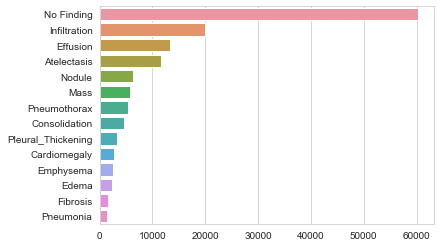

In [2]:
# read NIH data, the csv

df_NIH = pd.read_csv(r'C:\Users\Zijian\OneDrive - Cranfield University\Group project\NIH\Data_Entry_2017.csv')
# only keep the illnesss label and image names

df_NIH = df_NIH[['Image Index', 'Finding Labels']]
# create new columns for each illness
# total 14 thoracic disease

pathology_list = ['Cardiomegaly','Emphysema','Effusion','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia', 'No Finding'] #'Hernia',

for pathology in pathology_list :
    df_NIH[pathology] = df_NIH['Finding Labels'].apply(lambda x: 1.0 if pathology in x else 0.0)
# draw out the disease distribution

plt.figure(figsize=(15,10))
fig, ax = plt.subplots()

data1 = pd.melt(df_NIH,
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')

data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category', data=data1, ax=ax, order = data1['Category'].value_counts().index)
ax.set( ylabel="",xlabel="")


In [3]:
### This is for testing the code and choose 500 images randomly

df_NIH_ill = df_NIH[~df_NIH['Finding Labels'].isin(['No Finding'])]
df_NIH_heal= df_NIH[df_NIH['Finding Labels'].isin(['No Finding'])]
df_NIH_ill = df_NIH_ill.sample(n=500)
df_NIH_heal =df_NIH_heal.sample(n=100)
df_NIH_ill = df_NIH_ill.drop(['Finding Labels'], axis=1)
df_NIH_heal = df_NIH_heal.drop(['Finding Labels'], axis=1)


(<matplotlib.axes._subplots.AxesSubplot at 0x1cc8ee64548>,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
  <a list of 14 Text xticklabel objects>))

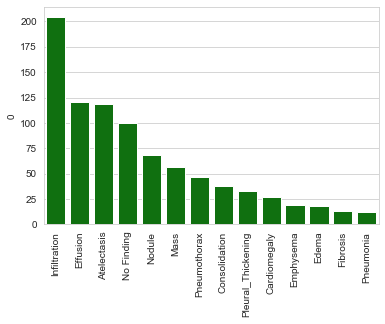

In [4]:
# create vector as ground-truth, will use as actuals to compare against our predictions later
# rename "xray" to classify other images

xray = pd.concat([df_NIH_heal, df_NIH_ill])
# for draw out the training percent

total = xray[pathology_list].sum().sort_values(ascending= False) 
clean_labels_df = total.to_frame() # convert to dataframe for plotting purposes
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90) # visualize results graphically


In [5]:
# read images 

print("[INFO] loading images...")
data = []
imagename = xray['Image Index'].values.tolist()
prepath= 'C:\\Users\\Zijian\\OneDrive - Cranfield University\\Group project\\NIH\\images\\images\\'

for each in imagename:
    image = cv2.imread(prepath+each)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    data.append(image)


[INFO] loading images...


In [6]:
# all values are in the range from 0 to 1

data = np.array(data)/255.0
# create labels from Xray dataframe

xray['labels'] = xray.apply(lambda target: [target[pathology_list].values], 1).map(lambda target: target[0])
labels = np.stack(xray['labels'].values)
labels = labels.astype(float)


In [7]:
# the data for training and the remaining 33% for testing

print("[INFO] create train test datasets...")

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.33, random_state=42) #stratify=labels,



[INFO] create train test datasets...


In [8]:
# some basic setting
# construct the argument parser and parse the arguments

ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True, help="path to input dataset")
ap.add_argument("-p", "--plot", type=str, default="plot.png", help="path to output loss/accuracy plot")
ap.add_argument("-m", "--model", type=str, default="covid19.model", help="path to output loss/accuracy plot")
args = vars(ap.parse_args())


usage: ipykernel_launcher.py [-h] -d DATASET [-p PLOT] [-m MODEL]
ipykernel_launcher.py: error: the following arguments are required: -d/--dataset


SystemExit: 2

In [9]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size

INIT_LR = 1e-3
EPOCHS = 25
BS = 8


In [10]:
# initialize the training data augmentation object

trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")


In [11]:
# load the VGG16 network, ensuring the head FC layer sets are left off

baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


In [12]:
# construct the head of the model that will be placed on top of the
# the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(14, activation="softmax")(headModel)


In [13]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)

model = Model(inputs=baseModel.input, outputs=headModel)


In [14]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process

for layer in baseModel.layers:
	layer.trainable = False


In [15]:
# compile our model

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="mean_squared_error", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network

print("[INFO] training head...")

H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 50 steps, validate on 198 samples
Epoch 1/25
50/50 [==============================] - 21s 410ms/step - loss: 0.0945 - accuracy: 0.1218 - val_loss: 0.0849 - val_accuracy: 0.1510
Epoch 2/25
50/50 [==============================] - 14s 287ms/step - loss: 0.0909 - accuracy: 0.1650 - val_loss: 0.0837 - val_accuracy: 0.1510
Epoch 3/25
50/50 [==============================] - 14s 286ms/step - loss: 0.0892 - accuracy: 0.1777 - val_loss: 0.0834 - val_accuracy: 0.1510
Epoch 4/25
50/50 [==============================] - 14s 286ms/step - loss: 0.0880 - accuracy: 0.1726 - val_loss: 0.0829 - val_accuracy: 0.1510
Epoch 5/25
50/50 [==============================] - 14s 287ms/step - loss: 0.0891 - accuracy: 0.1650 - val_loss: 0.0825 - val_accuracy: 0.1562
Epoch 6/25
50/50 [==============================] - 14s 286ms/step - loss: 0.0900 - accura

In [16]:
# make predictions on the testing set

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


[INFO] evaluating network...


In [17]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability

predIdxs = np.argmax(predIdxs, axis=1)


In [18]:
print(classification_report(testY.argmax(axis=1), predIdxs))



precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        40
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         3
          10       0.15      1.00      0.26        29
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00        39

    accuracy                           0.15       198
   macro avg       0.01      0.07      0.02       198
weighted avg       0.02      0.15      0.04       198



In [19]:
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


In [20]:
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])


In [21]:
print(cm)
print("acc: {:.6f}".format(acc))
print("sensitivity: {:.6f}".format(sensitivity))
print("specificity: {:.6f}".format(specificity))


[[ 0  0  0  0  0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 40  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 24  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 29  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 39  0  0  0]]
acc: 0.000000
sensitivity: nan
specificity: nan


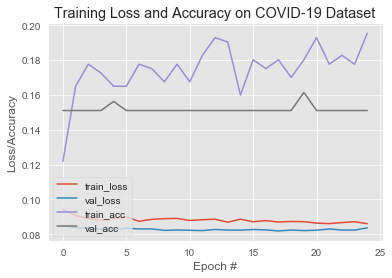

In [22]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


In [23]:
plt.savefig('performance.png', ppi=300)
# serialize the model to disk

print("[INFO] saving COVID-19 detector model...")
model.save("model", save_format="h5")


[INFO] saving COVID-19 detector model...


<Figure size 432x288 with 0 Axes>